# Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import feisty

## Configure testcase to run

TODO: this is using the first column (which I believe is shallowest); want to add deepest column as well.
That will require refactoring the yaml file and also changing test_ds.

In [3]:
def _comparison(matlab_vals, py_vals, row_name, full_table, seps):
    nstep = np.min([len(matlab_vals["time"].data), len(py_vals["time"].data)])
    nx = np.min([len(matlab_vals["X"].data), len(py_vals["X"].data)])
    matlab_vals = matlab_vals.isel(time=slice(0, nstep), X=slice(0, nx)).data
    py_vals = py_vals.isel(time=slice(0, nstep), X=slice(0, nx)).data
    rel_errs = np.where(matlab_vals != 0, np.abs((py_vals - matlab_vals) / matlab_vals), np.nan)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals == 0), 0, rel_errs)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals > 0), np.inf, rel_errs)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals < 0), -np.inf, rel_errs)

    if full_table or rel_err > 1e-12:
        max_inds = np.nonzero(np.abs(rel_errs) == np.max(np.abs(rel_errs)))
        t_ind = max_inds[0][0]
        x_ind = max_inds[1][0]
        matlab_val = matlab_vals[t_ind][x_ind]
        py_val = py_vals[t_ind][x_ind]
        rel_err = rel_errs[t_ind][x_ind]
        print(
            f"{seps[0]}{row_name} (t={t_ind}, X={x_ind}){seps[1]}{matlab_val:10.4e}{seps[2]}"
            + f"{py_val:10.4e}{seps[2]}{rel_err:10.4e}{seps[-1]}"
        )


def compare_nc(baseline_ds, test_da_or_ds, full_table=True, markdown_formatting="true"):
    if type(test_da_or_ds) == xr.Dataset:
        ds = test_da_or_ds
        da = None
        baseline_da = None
        table_header = ''
    else:
        da = test_da_or_ds
        ds = None
        da_dims = ["group", "fish"]
        da_dim = ''
        for dad in da_dims:
            if dad in da.dims:
                da_dim = dad
                break
        baseline_da = baseline_ds[da.name]
        table_header = da_dim
    if markdown_formatting:
        print(f"| {table_header} | Matlab Value | Python Value | Rel Err |")
        print("| --- | --- | --- | --- |")
        seps = ["| ", " | ", " | ", " |"]
    else:
        seps = ["", ": ", ", ", ""]
    if da is not None:
        for n, dimname in enumerate(da[da_dim]):
            _comparison(
                baseline_da.isel({da_dim: n}), da.isel({da_dim: n}), dimname.data, full_table, seps
            )
    else:
        for varname in ds:
            _comparison(
                baseline_ds.isel(zooplankton=0)[varname],
                ds.isel(zooplankton=0)[varname],
                varname,
                full_table,
                seps,
            )


def get_forcing(matlab_script, force_nonnegative=True):
    ds = xr.open_dataset(f'../matlab_baselines/{matlab_script}_forcing.nc')
    if force_nonnegative:
        for var in ['poc_flux_bottom', 'zooC', 'zoo_mort']:
            ds[var].data = np.where(ds[var].data > 0, ds[var].data, 0)
    return ds

In [4]:
# matlab_script = "test_case"
matlab_script = "test_locs3"
matlab_forcing_from_nc = get_forcing(matlab_script)
baselines_from_nc = xr.open_dataset(f'../matlab_baselines/{matlab_script}.nc')

if matlab_script == "test_case":
    testcase = feisty.driver.simulate_testcase("tanh_shelf", "cyclic")
elif matlab_script == "test_locs3":
    kwargs = {'forcing_yaml': './forcing.yaml', 'forcing_key': matlab_script}
    testcase = feisty.driver.simulate_testcase(
        "from_disk", "from_disk", domain_kwargs=kwargs, forcing_kwargs=kwargs
    )
else:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

In [5]:
compare_nc(matlab_forcing_from_nc, testcase.forcing)
print(
    f"\nMax diff in depth: {np.max(np.abs(matlab_forcing_from_nc['dep'].data - testcase.obj.domain_dict['bathymetry'].data))}"
)

|  | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| T_pelagic (t=0, X=0) | 4.7453e+00 | 4.7453e+00 | 0.0000e+00 |
| T_bottom (t=0, X=0) | 4.7647e+00 | 4.7647e+00 | 0.0000e+00 |
| poc_flux_bottom (t=0, X=0) | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 |
| zooC (t=0, X=0) | 7.0175e+00 | 7.0175e+00 | 0.0000e+00 |
| zoo_mort (t=0, X=0) | 5.2470e-02 | 5.2470e-02 | 0.0000e+00 |

Max diff in depth: 0.0


/glade/scratch/mlevy/tmpdir/ipykernel_141263/3502589495.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_errs = np.where(matlab_vals != 0, np.abs((py_vals - matlab_vals) / matlab_vals), np.nan)


## Run the model


In [6]:
%%time

nsteps = 365
make_plot = True
testcase.run(nsteps)

CPU times: user 1min 26s, sys: 153 ms, total: 1min 27s
Wall time: 1min 30s


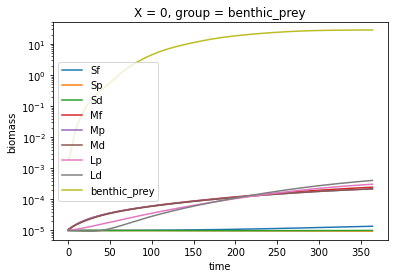

In [7]:
if nsteps > 1:
    if make_plot:
        for group in testcase.ds.group.data:
            testcase.ds.biomass.sel(group=group).isel(X=0).plot()
        if matlab_script == "test_case":
            plt.ylim([1e-6, 1])
        if matlab_script == "test_locs3":
            plt.ylim([5e-6, 50])
        plt.yscale("log")
        plt.legend(testcase.ds.group.data)

In [8]:
compare_nc(baselines_from_nc, testcase.ds["biomass"], nsteps)

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf (t=298, X=0) | 1.2378e-05 | 1.2378e-05 | 2.7371e-16 |
| Sp (t=0, X=0) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Sd (t=0, X=0) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Mf (t=61, X=0) | 4.1794e-05 | 4.1794e-05 | 3.2427e-16 |
| Mp (t=4, X=2) | 1.5865e-05 | 1.5865e-05 | 2.1356e-16 |
| Md (t=258, X=0) | 1.5325e-04 | 1.5325e-04 | 3.5373e-16 |
| Lp (t=187, X=2) | 3.0789e-04 | 3.0789e-04 | 3.5214e-16 |
| Ld (t=214, X=1) | 2.0739e-05 | 2.0739e-05 | 1.7971e-15 |
| benthic_prey (t=327, X=1) | 2.9618e-01 | 2.9618e-01 | 1.6868e-15 |
